# Data Processing
## Purpose
State the purpose of the notebook.
## Methodology
Quickly describle assumptions and processing steps.
## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- Todo 1;
- Todo 2;

## Results
Describe and comment the most important results.

# Setup
## Library import
We import all the required Python libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import regionmask
import cartopy.crs as ccrs
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utils

**set_lat_lon_attrs**

In [2]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [3]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    """Create masks of geographical regions"""
    # Create index column
    if 'index' not in df:
        df = df.reset_index(drop=True).reset_index()

    # Extract indexes and geoms that are large enough!
    id_ints = df['index'].values
    geoms = df['geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')


    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # get the ints not written to mask
    id_ints_not_in_mask = df[~df['index'].isin(id_ints_mask)]['index'].values
    
    if len(id_ints_not_in_mask) > 0: 
        print(f'Ints not in mask: {id_ints_not_in_mask}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    
    return da_mask, id_ints_not_in_mask

**number_of_digits**

In [4]:
def number_of_digits(x):
    """Get number of digits to the left/right of a decimal point"""
    # Number of digits to the left of the decimal point
    dig_left = int(np.log10(x))+1
    # Number of digits to the right of the decimal point
    if '.' in str(x):
        decList = [int(y) for y in list(str(x).split('.')[1])]
        dig_right = next((i for i, x in enumerate(decList) if x), None) + 1
    else:
        dig_right = 0
        
    return dig_left, dig_right

**find_nearest**

In [5]:
def find_nearest(array, value):
    """Find nearest value in numpy array"""
    array = np.asarray(array)
    
    # Get the mean step values
    step = np.abs(np.diff(array)).max()*1.5
    
    # Find the nearest values
    diff = np.abs(array - value)
    idx = np.argwhere((diff >= np.amin(diff) - step) & (diff <= np.amin(diff) + step))

    return idx

**get_xy_from_latlon**

In [6]:
def get_nearest_xy_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    idx_lon = find_nearest(lons, lon)
    idx_lat = find_nearest(lats, lat)
    
    # Check the identical rows in both arrays
    res = (idx_lon[:, None] == idx_lat).all(-1).any(-1)
    yx_positions = idx_lon[res]
    
    
    if yx_positions.shape[0] == 0:
        raise Exception("Sorry, lat/lon values outside data domain")   
    if yx_positions.shape[0] > 1:
        # If more than one identical rows take the row nearest to the mean value
        yx_positions = np.mean(yx_positions,axis=0).astype(int).reshape(1,2)

    # Get the x/y values
    x_position = yx_positions[0][1]
    y_position = yx_positions[0][0]
    
    x = ds.rlon.data[yx_positions[0][1]]
    y = ds.rlat.data[yx_positions[0][0]]

    return x_position, y_position, x, y

**get_nearest_latlon_from_latlon**

In [7]:
def get_nearest_latlon_from_latlon(ds, lat, lon, lon_name='lon', lat_name='lat'):
    """Return the x/y values for a given longitude/latitude values"""
    # Read all lon/lat values
    lons = ds[lon_name].data
    lats = ds[lat_name].data
    
    # Get mean lon/lat step size 
    mean_lat_size = np.abs(np.diff(lats)).mean()
    #print(mean_y_size)
    mean_lon_size = np.abs(np.diff(lons)).mean()
    
    # Round lon/lat values to the first decimal place
    dig_left, dig_right = number_of_digits(mean_lat_size) 
    if dig_right == 0: 
        lat = round(lat)
    else:
        lat = round(lat, dig_right)
        
    dig_left, dig_right = number_of_digits(mean_lon_size) 
    if dig_right == 0: 
        lon = round(lon)
    else:
        lon = round(lon, dig_right)
    
    # Find the positions of the nearest longitude/latitude values
    lon_positions = find_nearest(lons, lon)
    lat_positions = find_nearest(lats, lat)
    
    # If more than one identical rows take the row nearest to the mean value
    lon_position = round(np.mean(lon_positions))
    lat_position = round(np.mean(lat_positions))

    return lon_position, lat_position

**get_centroid_values**

In [8]:
def get_centroid_values(gdf, ds, da, id_ints_not_in_mask, logical_coordinates=False, lon_name='lon', lat_name='lat'):

    #Add geometries smaller than mean cell size into the mask
    print("Adding values for geometries smaller than mean cell size:")
    gdf_not_in_mask = gdf.iloc[id_ints_not_in_mask].copy()
    gdf_not_in_mask['centroid'] = gdf_not_in_mask['geometry'].apply(lambda x: x.centroid)
    
    values = []
    for id_int in tqdm(id_ints_not_in_mask):
        lon = gdf_not_in_mask['centroid'].loc[id_int].x
        lat = gdf_not_in_mask['centroid'].loc[id_int].y
        
        if logical_coordinates:
            # Get x/y positions for the corresponding longitude/latitude values
            x_pos, y_pos, x, y = get_nearest_xy_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        else:
            # Get longitude/latitude positions for the corresponding longitude/latitude values
            x_pos, y_pos = get_nearest_latlon_from_latlon(ds, lat, lon, lon_name=lon_name, lat_name=lat_name)
        
        # Replace cell value with new int
        values.append(da.data[:, y_pos, x_pos])
            
    return values

**display_figures**

In [182]:
def display_figures(gdf, gdf_ids, geometry, dataset, indicator, scenario, year):
    df = gdf[geometry].copy()
    df = df[(df['dataset'] == dataset) & (df['indicator'] == indicator) \
    & (df['scenario'] == scenario) & (df['year'] == year) ]
    
    df = pd.merge(gdf_vectors[geometry],  df, on=gdf_ids[geometry], how='left')
    
    fig = plt.figure(figsize=(25,10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=-0.5) 
    df.plot(ax=ax1, column='value', cmap='magma', legend=True, cax=cax, legend_kwds={'label': indicator})
    ax1.set_title(f'time = {year}, scenario = {scenario}')
    
    
    ax2.set_global()
    ds_rasters[dataset].sel(scenario=scenario).sel(time=years)[indicator].plot.pcolormesh(ax=ax2, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
    ax2.coastlines()
    ax2.set_ylim([lat_min-1,lat_max+1]);
    ax2.set_xlim([lon_min-1,lon_max+1]);

# Data import

## Fenómenos climáticos extremos (raster)
- ### Fire danger indicators
    - **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=overview)**

    - **[Documentation](https://datastore.copernicus-climate.eu/documents/sis-european-tourism/C3S_D422_Lot2_TEC_FWI_dataset_description_v2.pdf)**
    
    The dataset presents projections of fire danger indicators for Europe based upon the Canadian Fire Weather Index System (FWI) under future climate conditions. The FWI is a meteorologically based index used worldwide to estimate the fire danger and is implemented in the Global ECMWF Fire Forecasting model (GEFF). In this dataset, daily FWI values, seasonal FWI values, and other FWI derived, threshold-specific, indicators were modelled using the GEFF model to estimate the fire danger in future climate scenarios. These indicators include the number of days with moderate, high, or very high fire danger conditions as classified by the European Forest Fire Information System (EFFIS) during the northern hemisphere's fire season (June-September):
    
        - very low: <5.2
        - low: 5.2 - 11.2
        - moderate: 11.2 - 21.3
        - high: 21.3 - 38.0
        - very high: 38.0 - 50
        - extreme: >=50.0

        - **1.  Fire danger indicators:**
        
        The C3S European Tourism Sectoral Climate Impact Indicators (SCIIs) have been derived from the
daily outputs of the FWI model. Mean fire season FWI have been calculated, i.e. mean FWI for the
months from June to September, when most of the forest fires occur, as well as the number of days
per year with moderate/high/very high fire danger according to EFFIS homogenous
classification for the European domain.

    - **Variables:**
        - **Seasonal fire weather index:** 
        The mean fire weather index value over the European fire season (June-September). This is calculated as the sum of the daily fire weather index over the European fire season divided by the total number of days within this date range. The higher the index value, the more favorable the meteorological conditions to trigger a wildfire are.
    
- ### Heat waves and cold spells 
    - **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-heat-and-cold-spells?tab=overview)**

    - **[Documentation](http://urban-climate.copernicus-climate.eu/documents/Spells_extra_documentation.pdf)**
    
    The dataset contains the number of hot and cold spell days using different European-wide and national/regional definitions developed within the C3S European Health service. These heat wave and cold spell days are available for different future time periods and use different climate change scenarios.
        - **1.1 Heat wave definition:**
        
        A heat wave is considered as a period of at least three consecutive days on which the daily maximal temperature
exceeds the 99th percentile of the daily maximal temperatures of the May to September season of
the control period of 1971 to 2000.
        - **1.2 Cold spell definition:**
        
        A cold spell day is a day on which the daily minimum temperature is below the 10th percentile of
daily minimum temperature calculated for a 30-yr control period between 1961 and 1990. Since the
available EURO-CORDEX dataset starts at 1971, we select the 30-yr period of 1971-2000 as
reference period The condition has to be met for 6 consecutive days. The period is not defined so
we select the period between November and March. 
        - **2. Calculation of daily temperature time series:**
        
        In a next step, the relevant number of heat-wave days / cold-spell days is calculated for each year of
the period 1971 – 2100, for all the RCMs and scenarios under consideration. 
        - **3. Computation of yearly statistics:**
        
        In a next step, the relevant temperature statistics are calculated for each year of the period 1971 –
2100, for all the RCMs and scenarios under consideration.

        - **4.  Climate averages over 30 years:**
        
        To retrieve the climate signal from the annual time series, we take a running average over 30 years.
The year-labels always refers to the middle of the 30 year period; we thus report the average of the
statistics in the period [x – 15, x +15] for year x. The results are only available for the 100-year time
frame 1986 – 2085. 

    - **Variables:**
        - **Heat wave days:** 
        Number of hot days in a year using specific definitions.
        - **Cold spell days:** 
        Number of cold days in a year using specific definitions.
    
- ### Temperature statistics 
    - **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-temperature-statistics?tab=overview)**
    
    - **[Documentation](https://datastore.copernicus-climate.eu/documents/sis-european-health/Exposure_extra_documentation.pdf)**

    This dataset contains temperature exposure statistics for Europe (e.g. percentiles) derived from the daily 2 metre mean, minimum and maximum air temperature for the entire year, winter (DJF: December-January-February) and summer (JJA: June-July-August). These statistics were derived within the C3S European Health service and are available for different future time periods and using different climate change scenarios.
        - **1. Calculation of daily temperature time series:**
        
        At first, the hourly time series are converted to daily minimal, mean and maximal temperature time
series for the period 1971 - 2100. 
        - **2. Computation of yearly statistics:**
        
        In a next step, the relevant temperature statistics are calculated for each year of the period 1971 –
2100, for all the RCMs and scenarios under consideration.

        - **3.  Climate averages over 30 years:**
        
        To retrieve the climate signal from the annual time series, we take a running average over 30 years.
The year-labels always refers to the middle of the 30 year period; we thus report the average of the
statistics in the period [x – 15, x +15] for year x. Consequently, the results are only available for the
100-year time frame 1986 – 2085.
    
    - **Variables:**
        - **Maximum temperature:** 
    Daily maximum air temperature valid for a grid cell at the height of 2m above the surface, averaged over the year or season.
        - **Average temperature:**
    Daily average air temperature valid for a grid cell at the height of 2m above the surface, averaged over the year or season.
    
- ### Bioclimatic indicators 
    - **[Data source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-biodiversity-cmip5-regional?tab=overview)**
    
    - **[Documentation](https://datastore.copernicus-climate.eu/documents/sis-biodiversity/C3S_D427.3.1.1_Product_user_guide-Bioclimatic_indicators_CMIP5-1km_v2.3.pdf)**

    The dataset provides bioclimatic indicators derived from CMIP5 climate projections at 1 km x 1 km resolution for selected regions; Europe, Northern Brazil and Central Africa. This comprehensive set of bioclimatic indicators is specifically relevant for applications within the biodiversity and ecosystem services community.
        - **1. Input Data:**
        
        The Climate Model Intercomparison Project Phase 5 (CMIP5; Taylor et al., 2012) was used to provide
the future climate information for biodiversity. Its raw daily and monthly raw data on single levels
generated by Global Climate Models (GCMs) are the data source to calculate the **globally complete
dataset of bioclimatic indicators derived from CMIP5 climate projections (BIOCLIMATE_CMIP5)**.
They include daily and monthly raw data on single levels from GCMs and are obtained from the CDS.
The data originated from GCMs for two representative concentration pathways (RCPs) that provide
scenarios for future climate (i.e. RCP4.5 and RCP8.5). Ten GCMs were selected based on
data availability required for calculating all 76 indicators. We have used the **noresm1-m** model here.
        - **2. Indicator calculation:**
        
        Customized bioclimatic indicators were calculated by applying indicator definitions on raw daily and monthly climate data timeseries per year. Monthly, annual and 20-year window
statistics (for 1961-1980, 1981-2000, 2021-2040, 2041-2060, 2061-2080, 2081-2100) were calculated.

    - **Variables:**
        - **Precipitation in wettest quarter (BIO16):** 
        The mean of monthly mean precipitation during the wettest quarter, defined as the quarter with the highest monthly mean (of the daily mean) precipitation using a moving average of 3 consecutive months. To compute the total precipitation sum over the month, a conversion factor should be applied of 3600x24x91.3 (average number of days per quarter)*1000. This indicator corresponds to the official BIOCLIM variable BIO16.
        - **Annual precipitation (BIO12):** 
        Annual mean of the daily mean precipitation rate (both liquid and solid phases). This indicator corresponds to the official BIOCLIM variable BIO12. To compute the total precipitation sum over the year, a conversion factor should be applied of 3600x24x365x1000 (mm year-1).
        - **Aridity:** 
        Monthly potential evaporation divided by the monthly mean precipitation, averaged over the year.
        - **Dry spells:** 
        Maximum number of consecutive days of the dry spells within a year.

### Fire danger indicators

**Read data** 

In [10]:
data_dir = '../../datasets/raw/climate/dataset-sis-tourism-fire-danger-indicators/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        # convert to Dataset and concatenate by time
        if n == 0:
            ds_fire_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds_fire_sce = ds_fire_sce.assign_coords({"scenario": scenario})
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # add scenario coordinate
            ds = ds.assign_coords({"scenario": scenario})
            ds_fire_sce = xr.concat([ds_fire_sce, ds], dim='time')
            
    if ns == 0:
        ds_fire = ds_fire_sce.copy()
    else:
        ds_fire = xr.concat([ds_fire, ds_fire_sce.copy()], dim='scenario')
        
ds_fire

<xarray.Dataset>
Dimensions:        (time: 93, rlon: 424, rlat: 412, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2005-11-01 2006-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat           (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    lon            (rlat, rlon) float64 -10.06 -9.964 -9.864 ... 64.76 64.96
    lat            (rlat, rlon) float64 21.99 22.03 22.07 ... 66.81 66.75 66.69
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2005-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 59.63 61.19 ... 3.144
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Clip area**

Bounding box spain:

In [11]:
lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)

The corresponding x/y values.

In [12]:
x_min, y_min, x_max, y_max = (-25, -15, -10, -3)

In [13]:
ds_fire = ds_fire.sel(rlon=slice(x_min, x_max), rlat=slice(y_min, y_max)).copy()
ds_fire

<xarray.Dataset>
Dimensions:        (time: 93, rlon: 137, rlat: 109, scenario: 2, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2005-11-01 2006-11-01 ... 2097-11-01
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
Dimensions without coordinates: bnds
Data variables:
    rotated_pole   (scenario, time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    time_bnds      (scenario, time, bnds) datetime64[ns] 2005-11-01 ... 2098-...
    fwi-mean-jjas  (scenario, time, rlat, rlon) float64 nan nan ... 10.25 9.385
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Resample time**

In [14]:
ds_fire = ds_fire.assign_coords({"time": pd.DatetimeIndex(ds_fire.time.values).year+1})

In [15]:
da_fire = ds_fire['fwi-mean-jjas'].copy()
attrs = ds_fire.attrs
for n, years in enumerate([[2006,2020], [2021, 2040], [2041, 2060], [2061, 2080], [2081, 2098]]):
    da_fire_sce = da_fire.sel(time=slice(years[0],years[1])).mean('time').assign_coords({"time": f'{years[0]}-{years[1]}'})
    
    if n == 0:
        da = da_fire_sce.copy()
    else:
        da = xr.concat([da, da_fire_sce.copy()], dim='time')
        
ds_fire = da.to_dataset().assign_attrs(attrs)

In [16]:
ds_fire

<xarray.Dataset>
Dimensions:        (rlon: 137, rlat: 109, scenario: 2, time: 5)
Coordinates:
  * rlon           (rlon) float64 -24.96 -24.86 -24.75 ... -10.23 -10.11 -10.0
  * rlat           (rlat) float64 -14.9 -14.79 -14.69 ... -3.245 -3.135 -3.025
    lon            (rlat, rlon) float64 -10.43 -10.31 -10.2 ... 3.023 3.18 3.338
    lat            (rlat, rlon) float64 31.04 31.08 31.12 ... 46.69 46.71 46.73
  * scenario       (scenario) <U5 'rcp45' 'rcp85'
  * time           (time) <U9 '2006-2020' '2021-2040' ... '2081-2098'
Data variables:
    fwi-mean-jjas  (time, scenario, rlat, rlon) float64 nan nan ... 11.44 10.75
Attributes: (12/13)
    creation_date:  2019-06-19-T09:10:38Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-mean-jjas
    references:     van Wagner, C. E., (1987). Development and structure of a...
    ...             ...
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

**Display data**

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


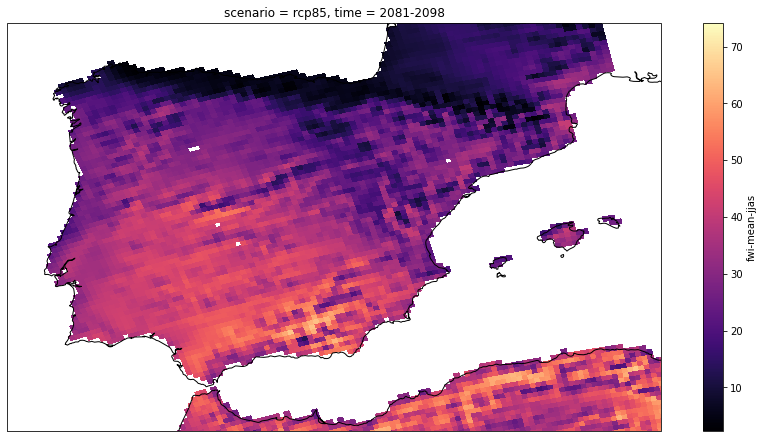

In [17]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_fire['fwi-mean-jjas'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Heat waves and cold spells 

**Read data** 

In [18]:
data_dir = '../../datasets/raw/climate/dataset-sis-heat-and-cold-spells/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        ds_heat_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
        # Add scenario coordinate
        ds_heat_sce = ds_heat_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_heat = ds_heat_sce.copy()
    else:
        ds_heat = xr.concat([ds_heat, ds_heat_sce.copy()], dim='scenario')
        
#Remove variables height and quantile
ds_heat = ds_heat.drop_vars(['height', 'quantile'])
        
ds_heat

<xarray.Dataset>
Dimensions:         (lat: 425, lon: 599, time: 100, scenario: 2)
Coordinates:
  * lat             (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon             (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time            (time) datetime64[ns] 1986-01-01 1987-01-01 ... 2085-01-01
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

In [19]:
ds_heat = ds_heat.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_heat

<xarray.Dataset>
Dimensions:         (lat: 78, lon: 137, time: 100, scenario: 2)
Coordinates:
  * lat             (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon             (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * time            (time) datetime64[ns] 1986-01-01 1987-01-01 ... 2085-01-01
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (scenario, time, lat, lon) float32 nan nan ... 26.48 26.35
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Resample time**

In [20]:
ds_heat = ds_heat.assign_coords({"time": pd.DatetimeIndex(ds_heat.time.values).year})
ds_heat = ds_heat.sel(time=[1986]+ list(np.arange(2000, 2090, 10)))
ds_heat = ds_heat.assign_coords({"time": np.array([f"{str(x-15)} - {str(x+15)}" for x in ds_heat.time.data])})
ds_heat

<xarray.Dataset>
Dimensions:         (lat: 78, lon: 137, time: 10, scenario: 2)
Coordinates:
  * lat             (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon             (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * time            (time) <U11 '1971 - 2001' '1985 - 2015' ... '2065 - 2095'
  * scenario        (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    HWD_EU_climate  (scenario, time, lat, lon) float32 nan nan ... 23.49 23.55
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Mon Jun 24 11:21:55 2019
    institution:    VITO (https://vito.be/en)

**Display data**

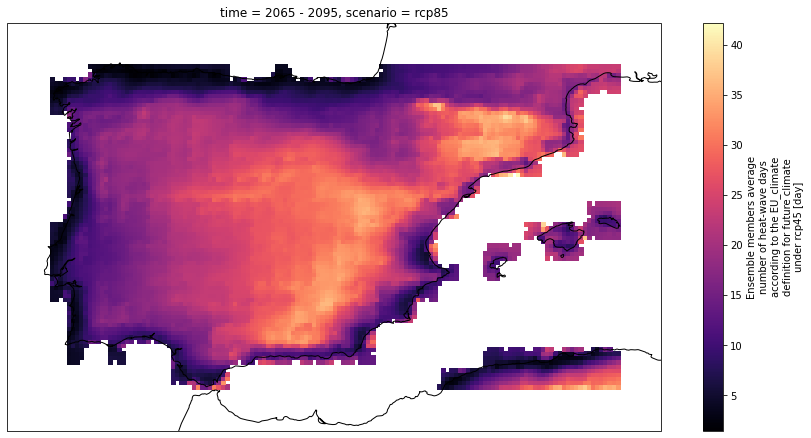

In [21]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_heat['HWD_EU_climate'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Temperature statistics 

#### Annual maximum temperature

**Read data** 

In [98]:
data_dir = '../../datasets/raw/climate/dataset-sis-temperature-statistics/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in [item for item in os.listdir(data_dir) if 'Tmax' in item] if scenario in i]):
        
        if n == 0:
            ds_temp_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # Assign new data variables to a Dataset
            ds_temp_sce = ds_temp_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            
        # Add scenario coordinate
        ds_temp_sce = ds_temp_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_temp = ds_temp_sce.copy()
    else:
        ds_temp = xr.concat([ds_temp, ds_temp_sce.copy()], dim='scenario')
        
#Remove variables height
ds_temp_max = ds_temp.drop_vars('height')

ds_temp_max

<xarray.Dataset>
Dimensions:           (time: 100, scenario: 2, lat: 425, lon: 599)
Coordinates:
  * time              (time) datetime64[ns] 1986-06-01 1987-06-01 ... 2085-06-01
  * lat               (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon               (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
    mean_Tmax_Yearly  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

In [99]:
ds_temp_max = ds_temp_max.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_temp_max

<xarray.Dataset>
Dimensions:           (time: 100, scenario: 2, lat: 78, lon: 137)
Coordinates:
  * time              (time) datetime64[ns] 1986-06-01 1987-06-01 ... 2085-06-01
  * lat               (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon               (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (scenario, time, lat, lon) float32 nan nan ... 34.28 34.24
    mean_Tmax_Yearly  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Resample time**

In [100]:
ds_temp_max = ds_temp_max.assign_coords({"time": pd.DatetimeIndex(ds_temp_max.time.values).year})
ds_temp_max = ds_temp_max.sel(time=[1986]+ list(np.arange(2000, 2090, 10)))
ds_temp_max = ds_temp_max.assign_coords({"time": np.array([f"{str(x-15)} - {str(x+15)}" for x in ds_temp_max.time.data])})
ds_temp_max

<xarray.Dataset>
Dimensions:           (time: 10, scenario: 2, lat: 78, lon: 137)
Coordinates:
  * time              (time) <U11 '1971 - 2001' '1985 - 2015' ... '2065 - 2095'
  * lat               (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon               (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 ... 4.0 4.1 4.2 4.3
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer  (scenario, time, lat, lon) float32 nan nan ... 33.98 33.94
    mean_Tmax_Yearly  (scenario, time, lat, lon) float32 nan nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

**Display data**

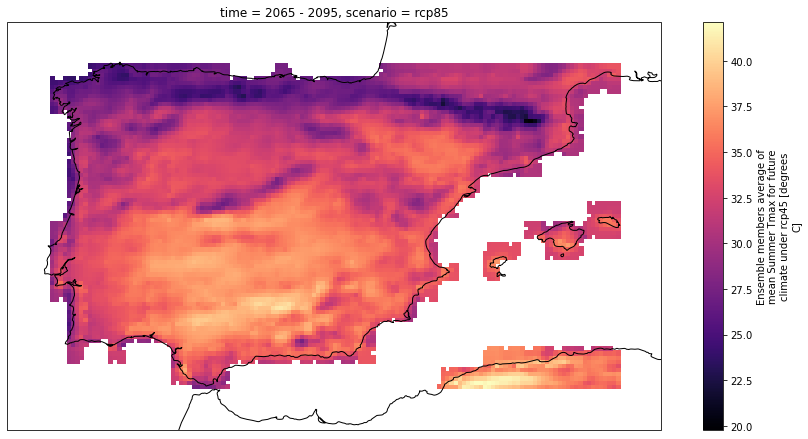

In [101]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_temp_max['mean_Tmax_Summer'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

#### Annual average temperature

**Read data** 

In [102]:
data_dir = '../../datasets/raw/climate/dataset-sis-temperature-statistics/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    for n, file in enumerate([i for i in [item for item in os.listdir(data_dir) if 'Tmean' in item] if scenario in i]):
        
        if n == 0:
            ds_temp_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
            
        else:
            ds = xr.open_dataset(data_dir+file, engine="netcdf4")
            # Assign new data variables to a Dataset
            ds_temp_sce = ds_temp_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            
        # Add scenario coordinate
        ds_temp_sce = ds_temp_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_temp = ds_temp_sce.copy()
    else:
        ds_temp = xr.concat([ds_temp, ds_temp_sce.copy()], dim='scenario')
        
#Remove variables height
ds_temp_mean = ds_temp.drop_vars('height')

ds_temp_mean

<xarray.Dataset>
Dimensions:            (scenario: 2, time: 100, lat: 425, lon: 599)
Coordinates:
  * lat                (lat) float64 30.1 30.2 30.3 30.4 ... 72.2 72.3 72.4 72.5
  * lon                (lon) float64 -24.9 -24.8 -24.7 -24.6 ... 34.7 34.8 34.9
  * time               (time) datetime64[ns] 1986-01-01 ... 2085-01-01
  * scenario           (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmean_Yearly  (scenario, time, lat, lon) float32 nan nan ... nan nan
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 16:43:59 2019
    institution:    VITO (https://vito.be/en)

**Clip area**

In [103]:
ds_temp_mean = ds_temp_mean.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_temp_mean

<xarray.Dataset>
Dimensions:            (scenario: 2, time: 100, lat: 78, lon: 137)
Coordinates:
  * lat                (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon                (lon) float64 -9.3 -9.2 -9.1 -9.0 ... 4.0 4.1 4.2 4.3
  * time               (time) datetime64[ns] 1986-01-01 ... 2085-01-01
  * scenario           (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmean_Yearly  (scenario, time, lat, lon) float32 nan nan ... 18.68
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 16:43:59 2019
    institution:    VITO (https://vito.be/en)

**Resample time**

In [104]:
ds_temp_mean = ds_temp_mean.assign_coords({"time": pd.DatetimeIndex(ds_temp_mean.time.values).year})
ds_temp_mean = ds_temp_mean.sel(time=[1986]+ list(np.arange(2000, 2090, 10)))
ds_temp_mean = ds_temp_mean.assign_coords({"time": np.array([f"{str(x-15)} - {str(x+15)}" for x in ds_temp_mean.time.data])})
ds_temp_mean

<xarray.Dataset>
Dimensions:            (scenario: 2, time: 10, lat: 78, lon: 137)
Coordinates:
  * lat                (lat) float64 36.0 36.1 36.2 36.3 ... 43.4 43.5 43.6 43.7
  * lon                (lon) float64 -9.3 -9.2 -9.1 -9.0 ... 4.0 4.1 4.2 4.3
  * time               (time) <U11 '1971 - 2001' '1985 - 2015' ... '2065 - 2095'
  * scenario           (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmean_Yearly  (scenario, time, lat, lon) float32 nan nan ... 18.42
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 16:43:59 2019
    institution:    VITO (https://vito.be/en)

**Display data**

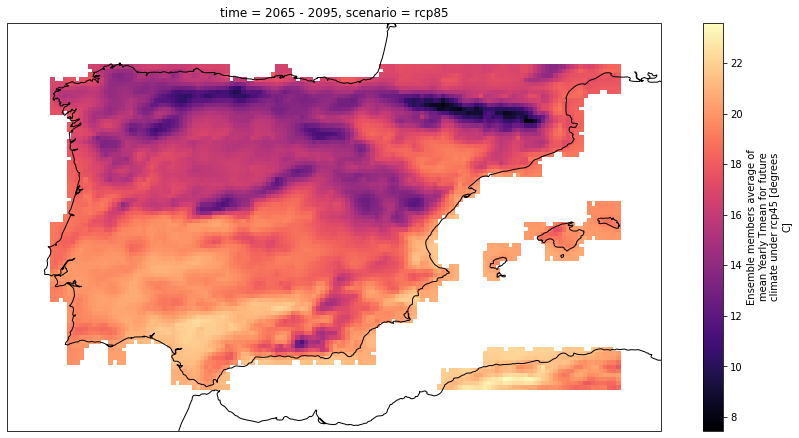

In [105]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_temp_mean['mean_Tmean_Yearly'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

#### Change in Annual Average Temperature
- **Variables:**
    - **Change annual average temperature:** 
    The Projected Change in annual average temperature shows the change in annual average temperature at 2 m above the surface compared to a baseline time period of 1971 - 2001.

In [107]:
attrs =  ds_temp_mean.attrs
for n, time in enumerate(ds_temp_mean.time.values):
    da = ds_temp_mean['mean_Tmean_Yearly'].sel(time=time) - ds_temp_mean['mean_Tmean_Yearly'].isel(time=0)
    da = da.assign_coords({"time": time}).rename('mean_Tmean_Yearly_change')
    
    if n == 0:
        da_change = da.copy()
    else:
        da_change = xr.concat([da_change, da.copy()], dim='time')
        
ds_change = da_change.to_dataset().assign_attrs(attrs)

In [109]:
ds_temp_mean['mean_Tmean_Yearly_change'] = ds_change['mean_Tmean_Yearly_change']

**Display data**

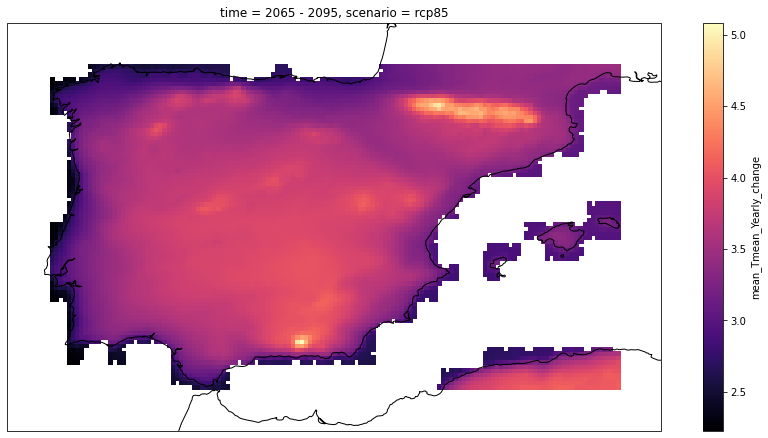

In [113]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_temp_mean['mean_Tmean_Yearly_change'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

### Merge Temperature statistics and Heat waves datasets

In [114]:
ds_temp_heat = ds_temp_max.copy()
ds_temp_heat['mean_Tmean_Yearly'] = ds_temp_mean['mean_Tmean_Yearly']
ds_temp_heat['mean_Tmean_Yearly_change'] = ds_temp_mean['mean_Tmean_Yearly_change']
ds_temp_heat['HWD_EU_climate'] = ds_heat['HWD_EU_climate']
ds_temp_heat

<xarray.Dataset>
Dimensions:                   (time: 10, scenario: 2, lat: 78, lon: 137)
Coordinates:
  * time                      (time) <U11 '1971 - 2001' ... '2065 - 2095'
  * lat                       (lat) float64 36.0 36.1 36.2 ... 43.5 43.6 43.7
  * lon                       (lon) float64 -9.3 -9.2 -9.1 -9.0 ... 4.1 4.2 4.3
  * scenario                  (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    mean_Tmax_Summer          (scenario, time, lat, lon) float32 nan ... 33.94
    mean_Tmax_Yearly          (scenario, time, lat, lon) float32 nan nan ... nan
    mean_Tmean_Yearly         (scenario, time, lat, lon) float32 nan ... 18.42
    mean_Tmean_Yearly_change  (time, scenario, lat, lon) float32 nan ... 3.471
    HWD_EU_climate            (scenario, time, lat, lon) float32 nan ... 23.55
Attributes:
    title:          Processed EURO-CORDEX future climate data for the health ...
    conventions:    CF-1.6
    project:        Copernicus Climate Change Service Sectoral Information Sy...
    source:         Processing of bias-corrected EURO-CORDEX data by VITO
    contact:        bd_rma@vito.be
    creation_date:  Tue May 21 21:08:09 2019
    institution:    VITO (https://vito.be/en)

### Bioclimatic indicators
    
**Read data** 

In [118]:
data_dir = '../../datasets/raw/climate/dataset-sis-biodiversity-cmip5-regional/'
for ns, scenario in enumerate(['rcp45', 'rcp85']):
    print(scenario)
    for n, file in enumerate([i for i in os.listdir(data_dir) if scenario in i]):
        print(file)
        if n == 0:
            ds_bio_sce = xr.open_dataset(data_dir+file, engine="netcdf4")
        else:
            if 'dry-spells_maximum-length' in file:
                # Ingest the dry spells variables as float32 and not as timedelta64
                raw = xr.open_dataset(data_dir+file, engine="netcdf4", decode_cf=False)
                del raw['dry-spells_maximum-length'].attrs['units']
                ds = xr.decode_cf(raw)
            else:
                ds = xr.open_dataset(data_dir+file, engine="netcdf4")
                
            # Assign new data variables to a Dataset
            ds_bio_sce = ds_bio_sce.assign({list(ds.keys())[-1]: ds[list(ds.keys())[-1]]})
            # Add scenario coordinate
            ds_bio_sce = ds_bio_sce.assign_coords({"scenario": scenario})
            
    if ns == 0:
        ds_bio = ds_bio_sce.copy()
    else:
        ds_bio = xr.concat([ds_bio.drop_vars('height'), ds_bio_sce.copy()], dim='scenario')

# Rename longitude/latitude to lon/lat
ds_bio = ds_bio.rename({"longitude": "lon", "latitude": "lat"})
ds_bio

rcp45
aridity_wettest-quarter_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
BIO12_noresm1-m_rcp45_r1i1p1_1960-2099-mean_v1.0.nc
rcp85
BIO12_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
aridity_wettest-quarter_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
BIO16_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc
dry-spells_maximum-length_noresm1-m_rcp85_r1i1p1_1960-2099-mean_v1.0.nc


<xarray.Dataset>
Dimensions:                    (lat: 4800, lon: 9600, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 32.0 32.01 32.02 ... 71.99 72.0
  * lon                        (lon) float64 -30.0 -29.99 -29.98 ... 49.99 50.0
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.3719 ... ...
    BIO16                      (scenario, time, lat, lon) float32 4.199e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 52.29 ... 2...
    BIO12                      (scenario, time, lat, lon) float32 2.177e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Clip area**

In [119]:
ds_bio = ds_bio.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)).copy()
ds_bio

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) datetime64[ns] 1979-01-01 ... 2090-01-01
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.4548 ... ...
    BIO16                      (scenario, time, lat, lon) float32 2.795e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 116.4 ... 44.8
    BIO12                      (scenario, time, lat, lon) float32 1.276e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Resample time**

In [120]:
ds_bio = ds_bio.assign_coords({"time": [1980, 1990, 2010, 2030, 2050, 2070, 2090]})
ds_bio = ds_bio.assign_coords({"time": np.array([f"{str(x-9)} - {str(x+10)}" for x in ds_bio.time.data])})
ds_bio

<xarray.Dataset>
Dimensions:                    (lat: 936, lon: 1646, time: 7, scenario: 2)
Coordinates:
  * lat                        (lat) float64 35.95 35.96 35.97 ... 43.74 43.75
  * lon                        (lon) float64 -9.387 -9.379 ... 4.312 4.321
  * time                       (time) <U11 '1971 - 1990' ... '2081 - 2100'
  * scenario                   (scenario) <U5 'rcp45' 'rcp85'
Data variables:
    aridity_wettest-quarter    (scenario, time, lat, lon) float32 0.4548 ... ...
    BIO16                      (scenario, time, lat, lon) float32 2.795e-08 ....
    dry-spells_maximum-length  (scenario, time, lat, lon) float32 116.4 ... 44.8
    BIO12                      (scenario, time, lat, lon) float32 1.276e-08 ....
Attributes:
    history:      Tue Dec 29 09:09:19 2020: ncpdq -a time,latitude,longitude ...
    Conventions:  CF-1.7
    Institution:  (C) VITO, Belgium
    References:   See documentation for full references at https://climate.co...
    Contact:      Please contact Copernicus User Support on the Copernicus Cl...
    Version:      v1
    Title:        C3S D427 SIS Biodiversity / Bio-climate indicators / aridit...
    Source:       CMIP5 dataset (rcp45 NorESM1-M r1i1p1) bias-adjusted to ERA...
    Licence:      ECMWF Copernicus licence 1.0

**Display data**

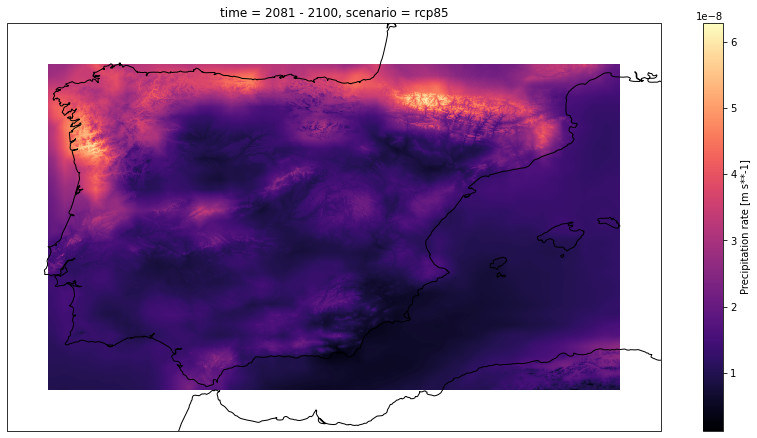

In [122]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ds_bio['BIO12'].isel(time=-1).sel(scenario='rcp85').plot.pcolormesh(ax=ax, cmap='magma', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);

**Put all raster data together** 

In [123]:
ds_rasters = {"Fire danger indicator": ds_fire,
             "Temperature statistics and heat waves": ds_temp_heat,
             "Bioclimatic indicators": ds_bio}

## Vector data 


## Regiones geograficas (vector)
- ### Comarcas Agrarias
    **[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

    La distribución de la superficie de España en `Comarcas Agrarias` agrupa los territorios en unidades espaciales intermedias entre la provincia y el municipio que sin personalidad jurídico-administrativa alguna, tiene un carácter uniforme desde el punto de vista agrario.
    
- ### Municipios de España
    **[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

### Comarcas Agrarias 
**Read data** 

In [124]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')
comarcas_agr.sort_values(['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [125]:
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]
comarcas_agr = comarcas_agr.reset_index(drop=True)
comarcas_agr

,CO_CCAA,DS_CCAA,CO_PROVINC,DS_PROVINC,CO_COMARCA,DS_COMARCA,geometry
0,1,Andalucía,4,Almeria,401,LOS VELEZ,"POLYGON ((-2.18190 37.89882, -2.17200 37.88869..."
1,1,Andalucía,4,Almeria,402,ALTO ALMAZORA,"POLYGON ((-2.30698 37.55521, -2.30604 37.55513..."
2,1,Andalucía,4,Almeria,403,BAJO ALMAZORA,"MULTIPOLYGON (((-1.90983 37.53787, -1.87940 37..."
3,1,Andalucía,4,Almeria,404,RIO NACIMIENTO,"POLYGON ((-2.82541 37.27830, -2.82478 37.27825..."
4,1,Andalucía,4,Almeria,405,CAMPO TABERNAS,"POLYGON ((-2.07134 37.29541, -2.07096 37.29533..."
...,...,...,...,...,...,...,...
341,17,Comunidad Valenciana,46,Valencia,4609,GANDIA,"POLYGON ((-0.23569 39.10358, -0.23488 39.10342..."
342,17,Comunidad Valenciana,46,Valencia,4610,VALLE DE AYORA,"POLYGON ((-1.05911 39.31525, -1.04755 39.30510..."
343,17,Comunidad Valenciana,46,Valencia,4611,ENGUERA Y LA CANAL,"POLYGON ((-0.77926 39.26022, -0.77850 39.25927..."
344,17,Comunidad Valenciana,46,Valencia,4612,LA COSTERA DE JATIVA,"MULTIPOLYGON (((-0.55119 39.00634, -0.55038 39..."


**Save as GeoJSON**

In [187]:
comarcas_agr.to_file('../../datasets/processed/comarcas_agrarias.geojson', driver='GeoJSON')  

**Display geometries**

<AxesSubplot:>

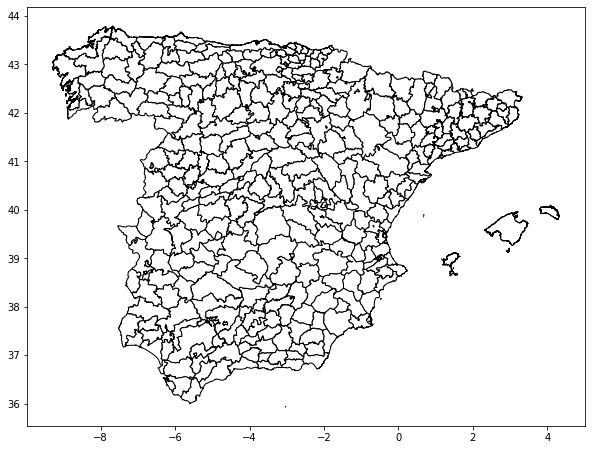

In [126]:
fig, ax = plt.subplots(figsize=(10,10))
comarcas_agr.plot(ax=ax, color='w', edgecolor='k')

### Municipios de España
**Read data** 

In [127]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [128]:
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]
municipios = municipios.reset_index(drop=True)
municipios

,FID,INSPIREID,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,SHAPE_Leng,SHAPE_Area,geometry
0,7792,ES.IGN.SIGLIM34121515001,34121515001,Abegondo,ES1,ES11,ES111,15001,0.633565,0.009293,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,7793,ES.IGN.SIGLIM34121515002,34121515002,Ames,ES1,ES11,ES111,15002,0.757739,0.008821,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,7794,ES.IGN.SIGLIM34121515003,34121515003,Aranga,ES1,ES11,ES111,15003,0.653707,0.013249,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,7795,ES.IGN.SIGLIM34121515004,34121515004,Ares,ES1,ES11,ES111,15004,0.434604,0.002024,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,7796,ES.IGN.SIGLIM34121515005,34121515005,Arteixo,ES1,ES11,ES111,15005,0.671846,0.010410,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."
...,...,...,...,...,...,...,...,...,...,...,...
8110,629,ES.IGN.SIGLIM34143030041,34143030041,La Unión,ES6,ES62,ES620,30041,0.293584,0.002608,"POLYGON ((-0.87089 37.57509, -0.87099 37.57610..."
8111,630,ES.IGN.SIGLIM34143030042,34143030042,Villanueva del Río Segura,ES6,ES62,ES620,30042,0.239119,0.001354,"POLYGON ((-1.33350 38.13457, -1.33294 38.13432..."
8112,631,ES.IGN.SIGLIM34143030043,34143030043,Yecla,ES6,ES62,ES620,30043,1.015005,0.062635,"POLYGON ((-1.34432 38.67705, -1.34407 38.67710..."
8113,632,ES.IGN.SIGLIM34143030901,34143030901,Santomera,ES6,ES62,ES620,30901,0.293271,0.004539,"POLYGON ((-1.10116 38.11349, -1.09939 38.11438..."


**Save as GeoJSON**

In [189]:
municipios.to_file('../../datasets/processed/municipios.geojson', driver='GeoJSON')  

**Display geometries**

<AxesSubplot:>

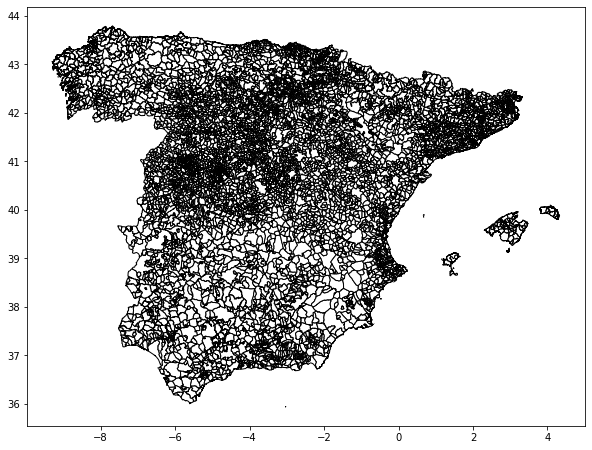

In [129]:
fig, ax = plt.subplots(figsize=(10,10))
municipios.plot(ax=ax, color='w', edgecolor='k')

**Put all vector data together** 

In [130]:
gdf_vectors = {"Comarcas agrarias": comarcas_agr,
             "Municipios": municipios}

# Zonal statistics

We convert raster data into vector by taking the mean value of each indicator at every geometry.

## Rasterize vector data
**Create the data mask by rasterizing the vector data**

In [131]:
da_masks = {}
ids_not_in_masks = {}
for ds_name, ds in ds_rasters.items():
    print(ds_name)
    da_mask = {}
    ids_not_in_mask = {}
    for gdf_name, gdf in gdf_vectors.items():
        print(gdf_name)
        #Create the data mask by rasterizing the vector data
        gdf = gdf.reset_index(drop=True).copy()
        da_mask[gdf_name], ids_not_in_mask[gdf_name] = create_ds_mask(gdf.copy(), ds, name=gdf_name.lower().replace(' ', '_'), lon_name='lon', lat_name='lat')
            
    da_masks[ds_name] = da_mask 
    ids_not_in_masks[ds_name] = ids_not_in_mask

Fire danger indicator
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 333
Ints not in mask: [186 191 193 196 208 210 212 213 284 298 299 307 332]
Municipios
Number of indexes: 8115
Number of geoms: 8115
Number of ints in mask: 2622
Ints not in mask: [   0    3    4 ... 8110 8111 8114]
Temperature statistics and heat waves
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 336
Ints not in mask: [186 204 208 210 212 213 284 299 307 332]
Municipios
Number of indexes: 8115
Number of geoms: 8115
Number of ints in mask: 3573
Ints not in mask: [   3    7   12 ... 8111 8113 8114]
Bioclimatic indicators
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346
Number of ints in mask: 345
Ints not in mask: [284]
Municipios
Number of indexes: 8115
Number of geoms: 8115
Number of ints in mask: 8105
Ints not in mask: [1031 1802 2757 2759 2764 6497 6881 7018 7074 7109]


**Display mask**

**Comarcas agrarias**

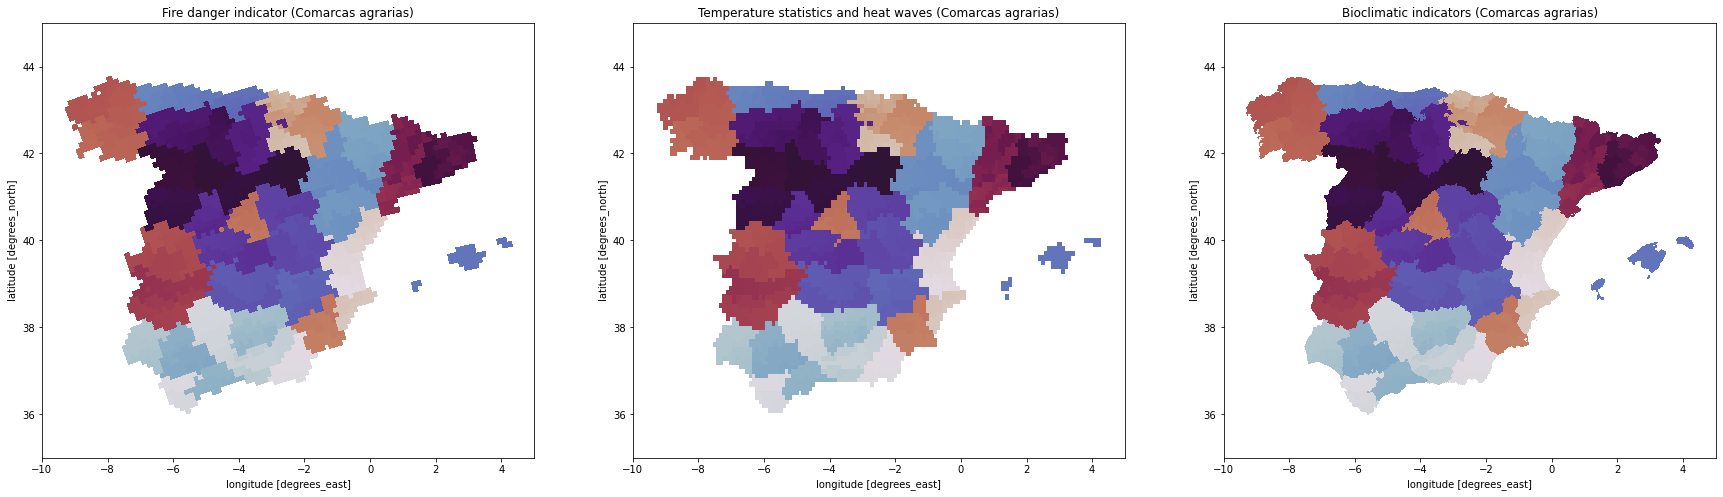

In [132]:
gdf_name = 'Comarcas agrarias'

fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for ds_name, masks in da_masks.items():
    mask=masks[gdf_name]
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='lon', y='lat', add_colorbar=False)
    axs[n].set_ylim([35, 45]);
    axs[n].set_xlim([-10, 5]);
    axs[n].set_title(f"{ds_name} ({gdf_name})");
    n+=1 

**Municipios**

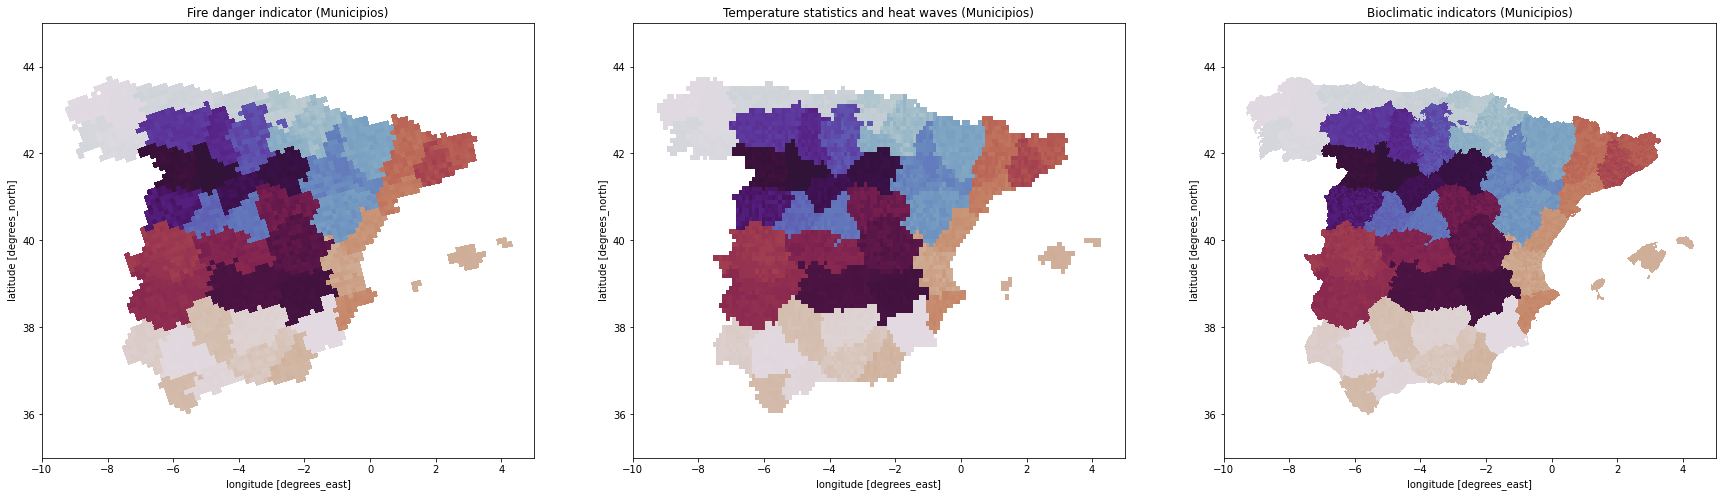

In [133]:
gdf_name = 'Municipios'

fig, axs = plt.subplots(1, 3, figsize=(30,8))

n=0
for ds_name, masks in da_masks.items():
    mask=masks[gdf_name]
    mask.plot.pcolormesh(ax=axs[n], cmap='twilight', x='lon', y='lat', add_colorbar=False)
    axs[n].set_ylim([35, 45]);
    axs[n].set_xlim([-10, 5]);
    axs[n].set_title(f"{ds_name} ({gdf_name})");
    n+=1

## Compute mean values for each indicator and time 
****Add mask as a new variable into the xarray.Dataset****

In [134]:
for ds_name, masks in da_masks.items():
    print(ds_name)
    for gdf_name, mask in masks.items():
        print(gdf_name)
        ds = ds_rasters[ds_name]
        ds[gdf_name.lower().replace(' ', '_')] = mask
        ds_rasters[ds_name] = ds

Fire danger indicator
Comarcas agrarias
Municipios
Temperature statistics and heat waves
Comarcas agrarias
Municipios
Bioclimatic indicators
Comarcas agrarias
Municipios


**Compute mean value over time**

In [156]:
gdf_indicators = gdf_vectors.copy()
for ds_name, masks in da_masks.items():
    print(ds_name)
    for gdf_name, mask in masks.items():
        print(gdf_name)
        gdf = gdf_indicators[gdf_name]
        ds = ds_rasters[ds_name]
        indicators = list(ds.keys())[:len(masks.keys())*-1]
        for indicator in indicators:
            print(indicator)
            for scenario in ds.scenario.data:
                print(scenario)
                mean_values = [] 
                for index in tqdm(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']):
                    if ds_name == 'Fire danger indicator':
                        mean_values.append(ds[indicator].sel(scenario=scenario).where(ds[gdf_name.lower().replace(' ', '_')] == index).mean(['rlon', 'rlat']).values)
                    else:
                        mean_values.append(ds[indicator].sel(scenario=scenario).where(ds[gdf_name.lower().replace(' ', '_')] == index).mean(['lon', 'lat']).values)
                
                #Add values for geometries smaller than mean cell size 
                if ds_name == 'Fire danger indicator':
                    centroid_values = get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), ids_not_in_masks[ds_name][gdf_name], logical_coordinates=True, lon_name='lon', lat_name='lat')
                else:
                    centroid_values = get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), ids_not_in_masks[ds_name][gdf_name], logical_coordinates=False, lon_name='lon', lat_name='lat')
                    
                    
                df = pd.DataFrame({'index': list(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']) + list(ids_not_in_masks[ds_name][gdf_name]),\
                                  f'{indicator} ({scenario})': mean_values + centroid_values,
                                  f'{indicator} ({scenario}) (time)': [list(ds.coords['time'].values)]*len(mean_values + centroid_values)})
                
                gdf = pd.merge(gdf.reset_index(), df, how = 'left', on = 'index').drop(columns='index')
            
            gdf_indicators[gdf_name] = gdf

Fire danger indicator
Comarcas agrarias
fwi-mean-jjas
rcp45


100%|██████████| 333/333 [00:00<00:00, 781.78it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 13/13 [00:00<00:00, 1755.11it/s]


rcp85


100%|██████████| 333/333 [00:00<00:00, 793.08it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 13/13 [00:00<00:00, 1753.64it/s]


Municipios
fwi-mean-jjas
rcp45


100%|██████████| 2622/2622 [00:03<00:00, 799.04it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 5493/5493 [00:02<00:00, 1878.48it/s]


rcp85


100%|██████████| 2622/2622 [00:03<00:00, 805.68it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 5493/5493 [00:02<00:00, 1859.23it/s]


Temperature statistics and heat waves
Comarcas agrarias
mean_Tmax_Summer
rcp45


100%|██████████| 336/336 [00:00<00:00, 807.92it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4034.92it/s]


rcp85


100%|██████████| 336/336 [00:00<00:00, 813.82it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4000.67it/s]


mean_Tmax_Yearly
rcp45


100%|██████████| 336/336 [00:00<00:00, 810.88it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4306.71it/s]


rcp85


100%|██████████| 336/336 [00:00<00:00, 808.47it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4359.98it/s]


mean_Tmean_Yearly
rcp45


100%|██████████| 336/336 [00:00<00:00, 811.89it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4027.18it/s]


rcp85


100%|██████████| 336/336 [00:00<00:00, 798.95it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3939.79it/s]


mean_Tmean_Yearly_change
rcp45


100%|██████████| 336/336 [00:00<00:00, 818.84it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4131.91it/s]


rcp85


100%|██████████| 336/336 [00:00<00:00, 796.86it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3993.43it/s]


HWD_EU_climate
rcp45


100%|██████████| 336/336 [00:00<00:00, 817.47it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4121.76it/s]


rcp85


100%|██████████| 336/336 [00:00<00:00, 811.37it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 4029.50it/s]


Municipios
mean_Tmax_Summer
rcp45


100%|██████████| 3573/3573 [00:04<00:00, 819.42it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4880.51it/s]


rcp85


100%|██████████| 3573/3573 [00:04<00:00, 822.17it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4906.43it/s]


mean_Tmax_Yearly
rcp45


100%|██████████| 3573/3573 [00:04<00:00, 822.76it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4965.58it/s]


rcp85


100%|██████████| 3573/3573 [00:04<00:00, 821.97it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4947.43it/s]


mean_Tmean_Yearly
rcp45


100%|██████████| 3573/3573 [00:04<00:00, 826.25it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4973.80it/s]


rcp85


100%|██████████| 3573/3573 [00:04<00:00, 822.71it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4947.65it/s]


mean_Tmean_Yearly_change
rcp45


100%|██████████| 3573/3573 [00:04<00:00, 811.00it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4879.35it/s]


rcp85


100%|██████████| 3573/3573 [00:04<00:00, 820.86it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4951.57it/s]


HWD_EU_climate
rcp45


100%|██████████| 3573/3573 [00:04<00:00, 821.19it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4965.68it/s]


rcp85


100%|██████████| 3573/3573 [00:04<00:00, 820.12it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 4542/4542 [00:00<00:00, 4909.03it/s]


Bioclimatic indicators
Comarcas agrarias
aridity_wettest-quarter
rcp45


100%|██████████| 345/345 [00:13<00:00, 25.16it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1408.43it/s]


rcp85


100%|██████████| 345/345 [00:13<00:00, 25.14it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1416.99it/s]


BIO16
rcp45


100%|██████████| 345/345 [00:13<00:00, 25.23it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1340.89it/s]


rcp85


100%|██████████| 345/345 [00:13<00:00, 25.24it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1128.71it/s]


dry-spells_maximum-length
rcp45


100%|██████████| 345/345 [00:13<00:00, 25.23it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1365.78it/s]


rcp85


100%|██████████| 345/345 [00:13<00:00, 25.21it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 1312.77it/s]


BIO12
rcp45


100%|██████████| 345/345 [00:13<00:00, 25.22it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 920.81it/s]


rcp85


100%|██████████| 345/345 [00:13<00:00, 25.22it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 1/1 [00:00<00:00, 943.39it/s]


Municipios
aridity_wettest-quarter
rcp45


100%|██████████| 8105/8105 [05:21<00:00, 25.22it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3682.77it/s]


rcp85


100%|██████████| 8105/8105 [05:21<00:00, 25.22it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3660.91it/s]


BIO16
rcp45


100%|██████████| 8105/8105 [05:21<00:00, 25.19it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3799.88it/s]


rcp85


100%|██████████| 8105/8105 [05:21<00:00, 25.22it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3770.16it/s]


dry-spells_maximum-length
rcp45


100%|██████████| 8105/8105 [05:21<00:00, 25.23it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3693.47it/s]


rcp85


100%|██████████| 8105/8105 [05:20<00:00, 25.29it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3661.55it/s]


BIO12
rcp45


100%|██████████| 8105/8105 [05:22<00:00, 25.16it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 1830.53it/s]


rcp85


100%|██████████| 8105/8105 [05:21<00:00, 25.24it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 10/10 [00:00<00:00, 3652.62it/s]


**Reorganice indicator table**

In [163]:
gdf_ids = {'Comarcas agrarias': ['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'],
           'Municipios': ['CODIGOINE']}

indicator_units = {
'fwi-mean-jjas': '', 
'mean_Tmax_Summer': 'ºC', 
'mean_Tmax_Yearly': 'ºC',
'mean_Tmean_Yearly': 'ºC', 
'mean_Tmean_Yearly_change': 'ºC', 
'HWD_EU_climate': 'days',
'aridity_wettest-quarter': '', 
'BIO16': 'm s-1', 
'dry-spells_maximum-length': 'days',
'BIO12': 'm s-1'
}

for gdf_name, gdf in gdf_indicators.items():
    print(gdf_name)
    df = pd.DataFrame(columns=gdf_ids[gdf_name] + ['dataset', 'indicator', 'scenario', 'value', 'year'])
    for ds_name, ds in ds_rasters.items():
        print(ds_name)
        indicators = list(ds.keys())[:len(masks.keys())*-1]
        for indicator in indicators:
            print(indicator)
            for scenario in ds.scenario.data:
                print(scenario)
                df_tmp = gdf[gdf_ids[gdf_name] + [f'{indicator} ({scenario})', f'{indicator} ({scenario}) (time)']]
                df_tmp.rename(columns={f'{indicator} ({scenario})': 'value', f'{indicator} ({scenario}) (time)': 'year'}, inplace=True)
                df_tmp['dataset'] = ds_name
                df_tmp['indicator'] = indicator
                df_tmp['scenario'] = scenario
                
                # Convert list-like columns (values and years) elements to separate rows
                df_tmp_melt = df_tmp.drop(["year"], axis = 1).copy()
                
                df_tmp_melt = df_tmp_melt['value'].apply(pd.Series)\
                .merge(df_tmp_melt, right_index = True, left_index = True)\
                .drop(["value"], axis = 1)\
                .reset_index()\
                .melt(id_vars = gdf_ids[gdf_name] + ['index', 'dataset', 'indicator', 'scenario'], value_name = "value")\
                .sort_values(['index', 'variable'])\
                .drop(["index", 'variable'], axis = 1)
                
                df_tmp_melt['year'] = df_tmp['year'].iloc[0]*len(df_tmp)
                
                df = pd.concat([df, df_tmp_melt])
                
                df.reset_index(drop=True, inplace=True)
                
    # Add units
    df['unit'] = df['indicator'].apply(lambda x: indicator_units[x])   
    
    gdf_indicators[gdf_name] = df

Comarcas agrarias
Fire danger indicator
fwi-mean-jjas
rcp45


KeyError: "['fwi-mean-jjas (rcp45)', 'fwi-mean-jjas (rcp45) (time)'] not in index"

In [171]:
gdf_indicators['Comarcas agrarias']

,CO_CCAA,CO_PROVINC,CO_COMARCA,dataset,indicator,scenario,value,year,unit
0,1,4,401,Fire danger indicator,fwi-mean-jjas,rcp45,2.863060e+01,2006-2020,
1,1,4,401,Fire danger indicator,fwi-mean-jjas,rcp45,3.090946e+01,2021-2040,
2,1,4,401,Fire danger indicator,fwi-mean-jjas,rcp45,3.303999e+01,2041-2060,
3,1,4,401,Fire danger indicator,fwi-mean-jjas,rcp45,3.323980e+01,2061-2080,
4,1,4,401,Fire danger indicator,fwi-mean-jjas,rcp45,3.582893e+01,2081-2098,
...,...,...,...,...,...,...,...,...,...
57431,17,46,4613,Bioclimatic indicators,BIO12,rcp85,1.690614e-08,2001 - 2020,m s-1
57432,17,46,4613,Bioclimatic indicators,BIO12,rcp85,1.612182e-08,2021 - 2040,m s-1
57433,17,46,4613,Bioclimatic indicators,BIO12,rcp85,1.630400e-08,2041 - 2060,m s-1
57434,17,46,4613,Bioclimatic indicators,BIO12,rcp85,1.427985e-08,2061 - 2080,m s-1


In [174]:
gdf_indicators['Municipios']

,CODIGOINE,dataset,indicator,scenario,value,year,unit
0,15001,Fire danger indicator,fwi-mean-jjas,rcp45,6.847982e+00,2006-2020,
1,15001,Fire danger indicator,fwi-mean-jjas,rcp45,7.403284e+00,2021-2040,
2,15001,Fire danger indicator,fwi-mean-jjas,rcp45,9.454822e+00,2041-2060,
3,15001,Fire danger indicator,fwi-mean-jjas,rcp45,9.433165e+00,2061-2080,
4,15001,Fire danger indicator,fwi-mean-jjas,rcp45,8.526856e+00,2081-2098,
...,...,...,...,...,...,...,...
1347085,30902,Bioclimatic indicators,BIO12,rcp85,9.235487e-09,2001 - 2020,m s-1
1347086,30902,Bioclimatic indicators,BIO12,rcp85,8.430820e-09,2021 - 2040,m s-1
1347087,30902,Bioclimatic indicators,BIO12,rcp85,8.503444e-09,2041 - 2060,m s-1
1347088,30902,Bioclimatic indicators,BIO12,rcp85,6.696378e-09,2061 - 2080,m s-1


**Save tables**

In [175]:
for gdf_name in gdf_indicators.keys():
    name = gdf_name.lower().replace(' ', '_')
    gdf_indicators[gdf_name].to_csv(f'../../datasets/processed/climate_indicators_{name}.csv', index = False)

**Display output/input figures**

In [180]:
dataset = 'Temperature statistics and heat waves'
indicator = 'mean_Tmean_Yearly_change'
scenario = 'rcp85'
year = '2065 - 2095'

**Comarcas agrarias**

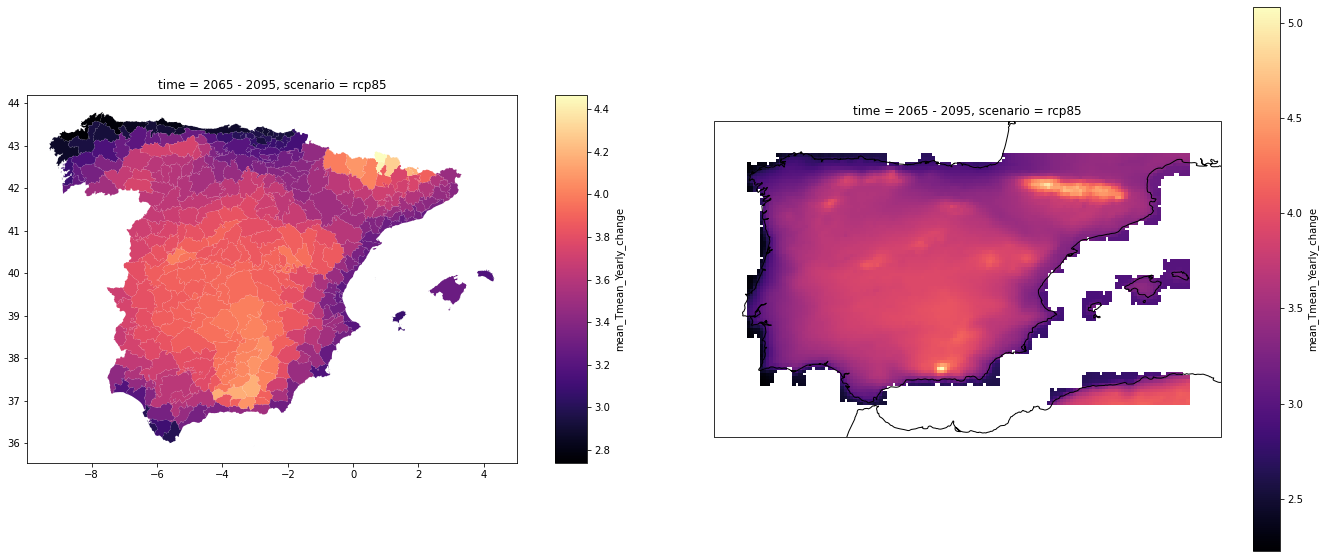

In [184]:
geometry = 'Comarcas agrarias'

display_figures(gdf_indicators, gdf_ids, geometry, dataset, indicator, scenario, year)

**Municipios**

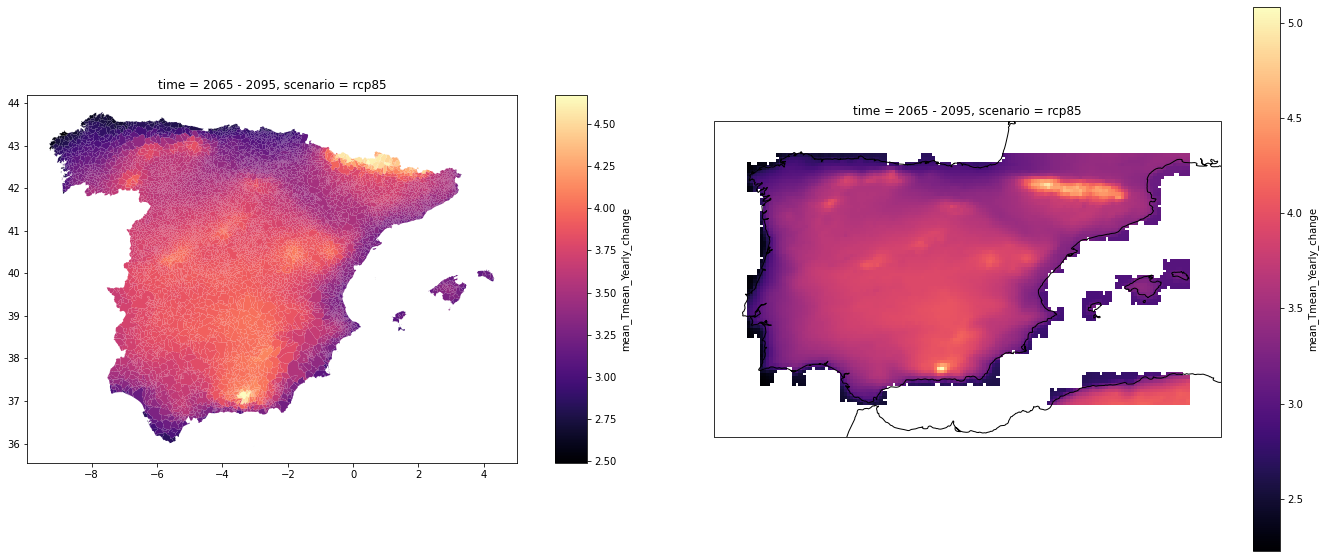

In [185]:
geometry = 'Municipios'

display_figures(gdf_indicators, gdf_ids, geometry, dataset, indicator, scenario, years)